# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


let's see what Juan thinks as per [here](https://github.com/AtMostafa/notebook/blob/main/meetings-with-juan/2021-07-22.mdhttps://github.com/AtMostafa/notebook/blob/main/meetings-with-juan/2021-07-22.md). **WHY** is it not different (higher CCs) compared to other across area/animal comparisons?

## Control

Compare it  with the NN paper, fig4 (M1 dynamics):  
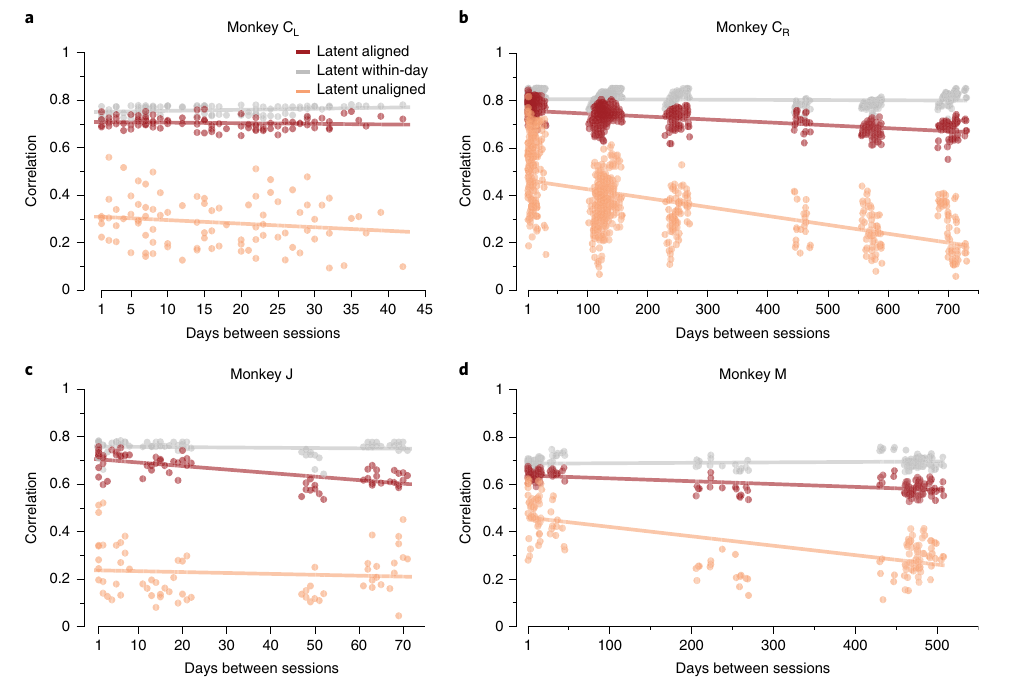  

### Details
- **animal**: $C_L$  is Chewie
- **window**: For *M1* it is $-120ms \sim +420ms$ and for *PMd* from $-390ms  \sim +60ms$
- **dim**: it is 10 for M1 and 15 for PMd
- **preprocessing**: 
    - remove firing rate below 1Hz overall
    - bin to 30ms
    - square root transform
    - smooth by Gaussian kernel, $\sigma=50ms$
    
Let's reproduce the gray dots: within-day CCs for one or two animals

In [2]:
if "__file__" not in dir():
    ANIMAL = 'Chewie'
    BIN_SIZE = .03  # sec
    WINDOW_prep = (-.39, .06)  # sec
    WINDOW_exec = (-.12, .42)  # sec
    AREA = 'M1'

    fileList = [root/ANIMAL/dataset for dataset in GoodDataList[AREA][ANIMAL]]


    df_data_M1=[]
    for fname in fileList:
        df = dt.load_pyal_data(fname)
        df_data_M1.append(df)
    #     dt.summary(df)

Finding the minimum number of trials per target across all datasets

and some other parameters

In [5]:
if "__file__" not in dir():

    df_M1_ready = [defs.prep_general(df) for  df in df_data_M1]


    n_shared_trial = np.inf
    data_list = df_M1_ready
    n_components = 10
    field = f'{AREA}_rates'

    for df in data_list:
        for target in range(8):
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)
    print(f'{n_shared_trial=}')

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df_,epoch_fun=defs.exec_epoch)
    n_timepoints = int(df_[field][0].shape[0])
    print(f'{n_timepoints=}')

/home/msafaie/REPOS/MyPyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and

n_shared_trial=17
n_timepoints=15


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [ ]:
if "__file__" not in dir():

    AllData = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, n_components))

    print(f'{AllData.shape=}')

    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df,epoch_fun=exec_epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        for target in range(8):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            rng.shuffle(all_id)
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__._pca):
                AllData[session,target,trial, :, :] = trial_rates

do the CCA calculation

In [7]:
if "__file__" not in dir():
    n_iter = 100
    trialList = np.arange(n_shared_trial)

    CCs=[]
    for session, sessionData in enumerate(AllData):
        r = []
        for n in range(n_iter):
            rng.shuffle(trialList)
            # non-overlapping randomised trials
            trial1 = trialList[:n_shared_trial//2]
            trial2 = trialList[-n_shared_trial//2:-1]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
            r.append(np.mean(dt.canoncorr(data1, data2)[:4]))
        CCs.append(r)
    CCs = np.array(CCs).T

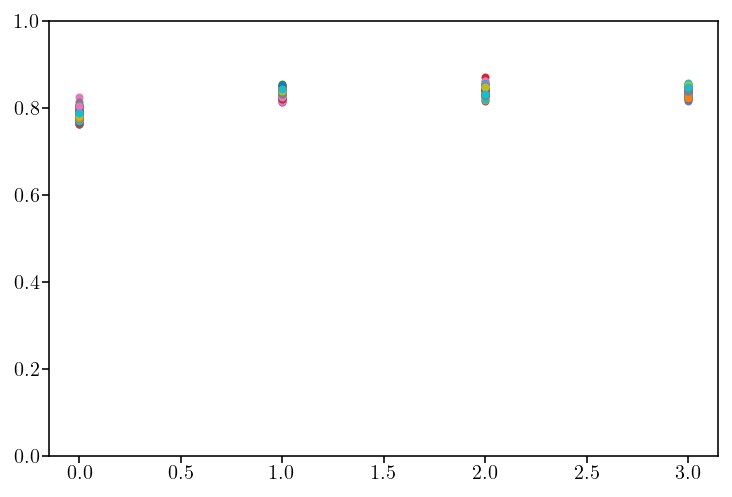

In [8]:
if "__file__" not in dir():
    plt.plot(CCs.T,'.')
    plt.ylim([0,1])

the average distribution of CCs for each session

In [9]:
if "__file__" not in dir():

    n_iter = 100
    trialList = np.arange(n_shared_trial)

    CCs=[]
    for session, sessionData in enumerate(AllData):
        r = []
        for n in range(n_iter):
            rng.shuffle(trialList)
            # non-overlapping randomised trials
            trial1 = trialList[:n_shared_trial//2]
            trial2 = trialList[-(n_shared_trial//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCs.append(np.array(r))
    CCs = np.array(CCs).T

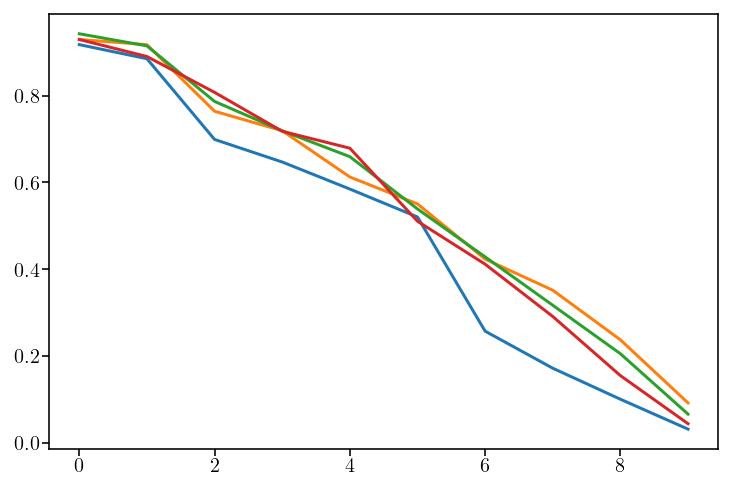

In [10]:
if "__file__" not in dir():
    for i in range(4):
        plt.plot(np.mean(CCs[:,:,i],axis=1))

### include all datasets

let's redo the above for all the datasets

In [2]:
warnings.filterwarnings("ignore")
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))

single_FileList1 = []
for I, _ in enumerate(full_list_MCx):
    single_FileList1.append(I)



warnings.filterwarnings("ignore")
side1df = [allDFs_MCx[i] for i in single_FileList1]
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)

warnings.filterwarnings("default")

In [4]:
n_iter = 1000
n_shared_trial1 = AllData1.shape[2]
trialList1 = np.arange(n_shared_trial1)


CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1)
CC_upper_bound_MCx = np.percentile(CCs1, 99, axis=1).T


if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variable: `CC_upper_bound_MCx` holds the upper bound correlations')
    del allDFs_MCx, side1df

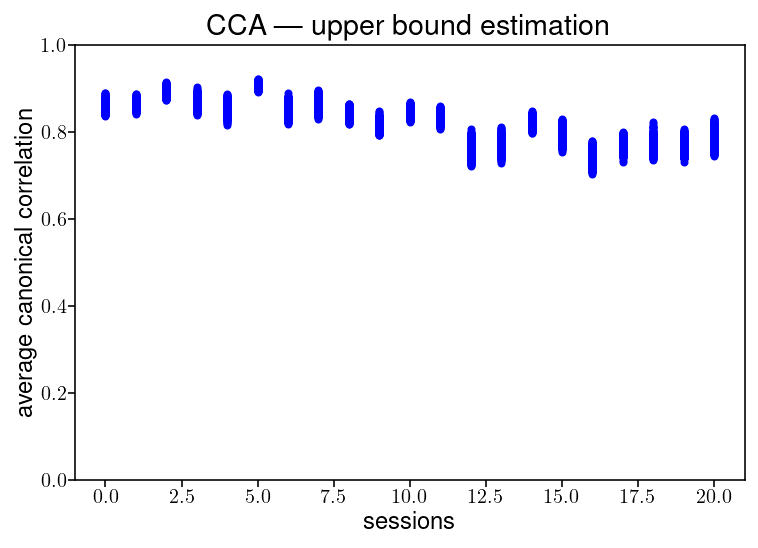

In [5]:
if "__file__" not in dir():
    M1_Lines = plt.plot(np.mean(CCs1[...,:4],axis=-1),'b.', label='MCx')
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('average canonical correlation')
    plt.title('CCA --- upper bound estimation', usetex=True);

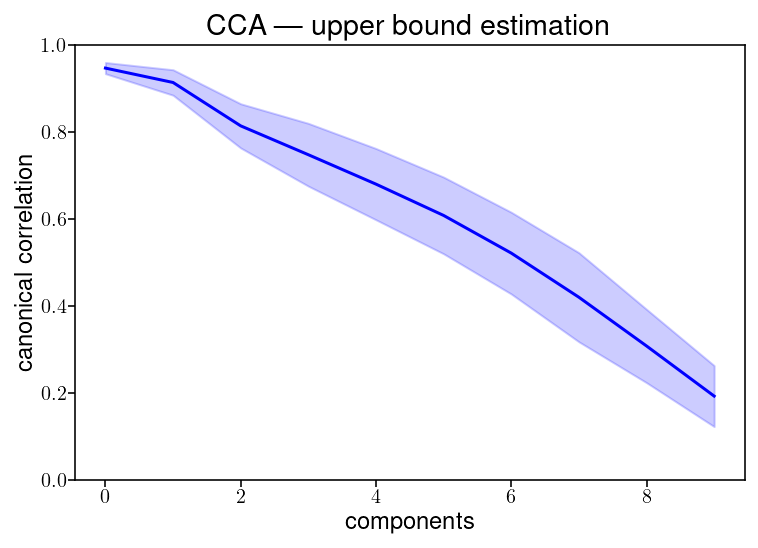

In [6]:
if "__file__" not in dir():
    _,ax = plt.subplots()
    M1_Lines,_ = utility.shaded_errorbar(ax, CC_upper_bound_MCx, color='b', label='MCx')

    plt.ylim([0,1])
    plt.xlabel('components')
    plt.ylabel('canonical correlation')
    plt.title('CCA --- upper bound estimation', usetex=True);